# Motivating examples
This document shows how SparseSC can be used in places where simple difference-in-differences can't.

## Basic setup

In [15]:
%matplotlib inline
#The below will keep the inline backend from showing figures on every plot call (allow returning plots that can be modified). but will have to auto close plots after showing
%config InlineBackend.close_figures = False

#Load code
import numpy as np
import random
import matplotlib.pyplot as plt

try:
    import SparseSC as SC
except ImportError:
    raise RuntimeError("SparseSC is not installed. use 'pip install -e .' from repo root to install in dev mode")

exec(open("./example_graphs.py").read()) #if we don't want an __init.py__

def simple_summ(fit, Y):
    print("V_pen=%s, W_pen=%s" % (fit.fitted_v_pen, fit.fitted_w_pen))
    print("V=%s" % np.diag(fit.V))
    print("Treated weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[0,49], fit.sc_weights[0,99], sum(fit.sc_weights[0,:])))
    print("Sim Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[1,49], fit.sc_weights[1,99], sum(fit.sc_weights[1,:])))
    print("Uns Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[51,49], fit.sc_weights[51,99], sum(fit.sc_weights[51,:])))
    Y_sc = fit.predict(Y)
    print("Treated diff: %s" % (Y - Y_sc)[0,:])


In [16]:
#make sure the results are the same each time we run
random.seed(12345) 
np.random.seed(12345)

Setup common data parameters

In [17]:
N1,N0_sim,N0_not = 2,50,50
N0 = N0_sim + N0_not
N=N1+N0
treated_units = range(N1)
control_units = list(set(range(N)) - set(treated_units))
T0,T1 = 5, 5
T=T0+T1
unit_treatment_periods = np.full((N), -1)
unit_treatment_periods[treated_units] = T0
proto_te = np.hstack((np.zeros((1,T0)), np.full((1,T0), 2)))

## Differential Trends

In [18]:
proto_sim = np.array(range(0,T,1),ndmin=2)
proto_not = np.array(range(0,2*T,2),ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)+ \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

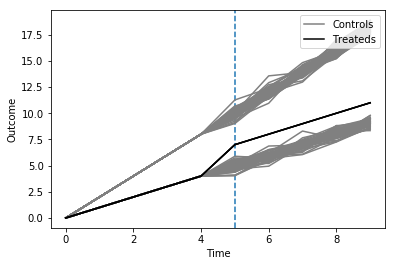

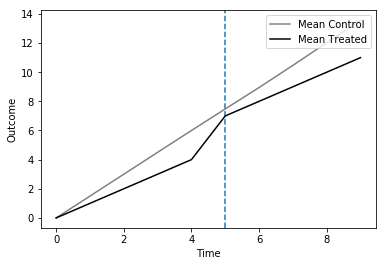

In [19]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
plt.show(raw_all)
plt.close('all')

Analyze

In [20]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret = SC.estimate_effects(Y, unit_treatment_periods, max_n_pl=200) 
#V_penalty = ret.fits[T0].V_penalty
#simple_summ(ret_full.fits[T0], Y)
#ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001, ret_CI=True)
simple_summ(ret.fits[T0], Y)

V_pen=15284132.4692, W_pen=3.10370712167e-06
V=[-0.          0.03333287  0.13333308  0.30000011  0.53333394]
Treated weights: sim=0.00800000033564, uns=0.00600000015153, sum=0.70000000874
Sim Con weights: sim=0.00800000033564, uns=0.00600000015153, sum=0.70000000874
Uns Con weights: sim=0.0, uns=0.00604437845565, sum=0.697781025096
Treated diff: [  0.00000000e+00  -5.26050981e-10  -1.05210196e-09  -1.57815316e-09
  -2.10420392e-09   2.01889999e+00   2.04056736e+00   2.02041119e+00
   1.98245217e+00   1.95467783e+00]


Visualize

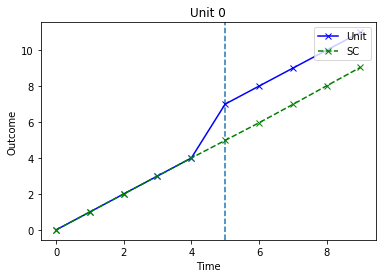

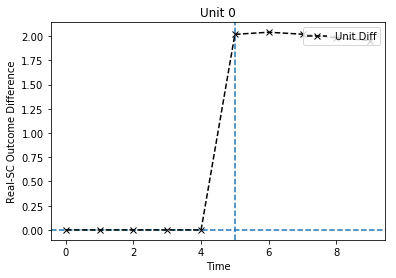

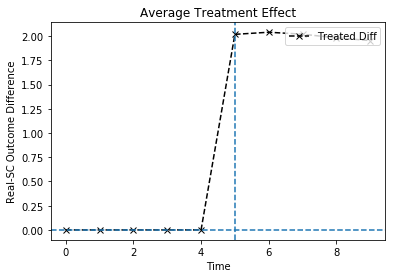

In [21]:
Y_sc = ret.fits[T0].predict(Y)
[sc_raw, sc_diff] = ind_sc_plots(ret, T0, 0)
sc_raw.axes[0].set_title("Unit 0")
sc_diff.axes[0].set_title("Unit 0")
[te] = te_plot(ret)
te.axes[0].set_title("Average Treatment Effect")
plt.show()
plt.close('all')

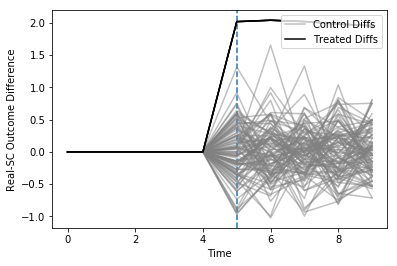

In [22]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
plt.show()
plt.close('all')

## Different cycles 

In [23]:
proto_sim = np.array([0,1,4,3,4,5,6,9,8,9],ndmin=2)
proto_not = np.array([0,3,2,4,3,5,4,6,5,7],ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

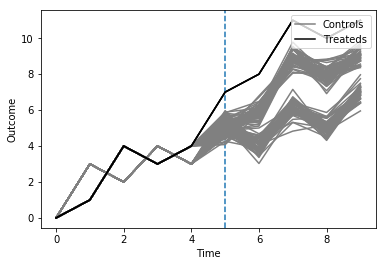

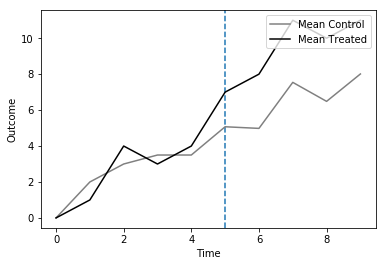

In [24]:
[raw_all, raw_means] = raw_plots(Y, treated_units, control_units, T0)
plt.show()
plt.close('all')

Analyze

In [ ]:
#Currently the built-in joint opimization of penalties isn't great, so do two steps
ret = SC.estimate_effects(Y, unit_treatment_periods, max_n_pl=200)
#V_penalty = ret_full.fits[T0].V_penalty
#simple_summ(ret_full.fits[T0], Y)
#ret = SC.estimate_effects(Y[:,:T0], Y[:,T0:], treated_units, covariate_penalties=[V_penalty], weight_penalty=0.00001, ret_CI=True)
simple_summ(ret.fits[T0], Y)

Visualize

In [ ]:
Y_sc = ret.fits[T0].predict(Y)
[sc_raw, sc_diff] = ind_sc_plots(ret, T0, 0)
sc_raw.axes[0].set_title("Unit 0")
sc_diff.axes[0].set_title("Unit 0")
[te] = te_plot(ret)
te.axes[0].set_title("Average Treatment Effect")
plt.show()
plt.close('all')

In [ ]:
diffs = Y - Y_sc
diffs_plt = diffs_plot(diffs, treated_units, control_units)
plt.show()
plt.close('all')